In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np
import cv2
import mat73
import random

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision as tv
import torch.nn.functional as F
from torch import Tensor

import albumentations as A

In [2]:
data_path = "/media/mountHDD2/nyu/nyu_depth_v2_labeled.mat"
raw_data = mat73.loadmat(data_path)

ERROR:root:ERROR: MATLAB type not supported: containers.Map, (uint32)


In [3]:
transform_lst = [
    A.HorizontalFlip(p=0.2),    
    A.OneOf([
        A.GaussNoise(var_limit=(2.0, 5.0)),
        A.RandomRain(),
        A.RandomSunFlare(src_radius=150) #Make Flare
    ], p=0.2),
    A.OneOf([
        A.MotionBlur(p=.2),
        A.MedianBlur(blur_limit=3, p=0.1),
        A.Blur(blur_limit=3, p=0.2),
    ], p=0.2),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=3, p=0.3,
                      border_mode = cv2.BORDER_CONSTANT),
    A.OneOf([
        A.OpticalDistortion(p=0.3),
        A.GridDistortion(p=0.1),
        A.PiecewiseAffine(p=0.3),
    ], p=0.2),
    A.OneOf([
        A.CLAHE(clip_limit=2),
        A.Sharpen(),
        A.Emboss(),
        A.RandomBrightnessContrast(),   
        A.Downscale(interpolation = {
            "downscale": cv2.INTER_NEAREST,
            "upscale": cv2.INTER_NEAREST
        }),
    ], p=0.3),
    A.OneOf([
        A.HueSaturationValue(p=0.3),
        A.ColorJitter(p=0.3),
    ], p= 0.3),
    A.RGBShift(p=0.2),
    A.RandomShadow(p=0.2),
    A.ElasticTransform(
        p=0.2, border_mode = cv2.BORDER_CONSTANT,
        alpha_affine = 20
    )
]

In [4]:
class NYU(Dataset):
    def __init__(self, raw_data, aug = False, resize = None):
        super().__init__()

        self.cls_cnt = len(raw_data["names"]) + 1
        self.aug = aug
        self.images = np.moveaxis(raw_data["images"], -1, 0)
        self.masks = np.moveaxis(raw_data["labels"], -1, 0)
        self.resize = A.Compose(
            [
                A.Resize(resize[0], resize[1])
            ]
        ) if resize else None

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, idx):
        img = self.images[idx]
        mask = self.masks[idx]

        if self.resize is not None:
            resized = self.resize(image = img, mask = mask)
            img = resized['image']
            mask = resized['mask']
        
        if self.aug:
            random.shuffle(transform_lst)
    
            transform = A.Compose(transform_lst)
    
            transformed = transform(image = img, mask = mask)
            
            img = transformed['image']
            mask = transformed['mask']

        torch_image = torch.from_numpy(img).permute(-1, 0, 1)
        torch_mask = F.one_hot(
            torch.from_numpy(mask.astype(np.int64)).unsqueeze(0), self.cls_cnt
        ).permute(0, 3, 1, 2)[0].float()

        return (torch_image, torch_mask)

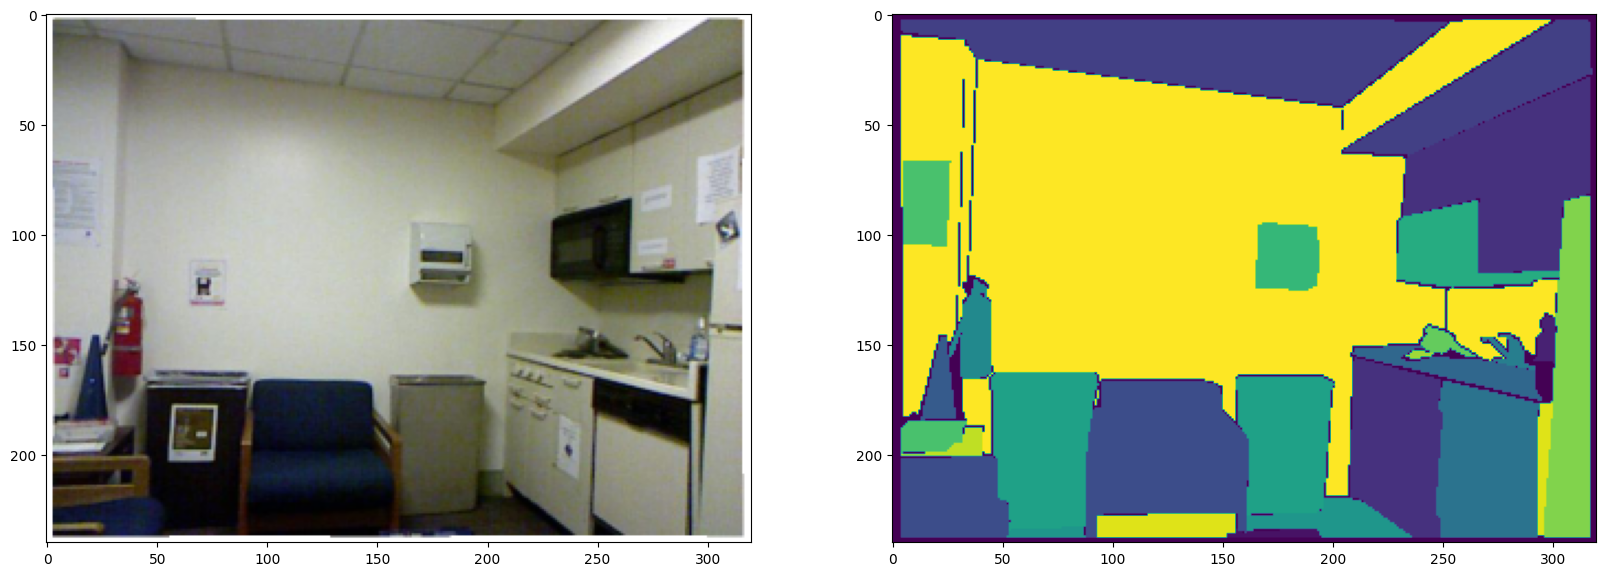

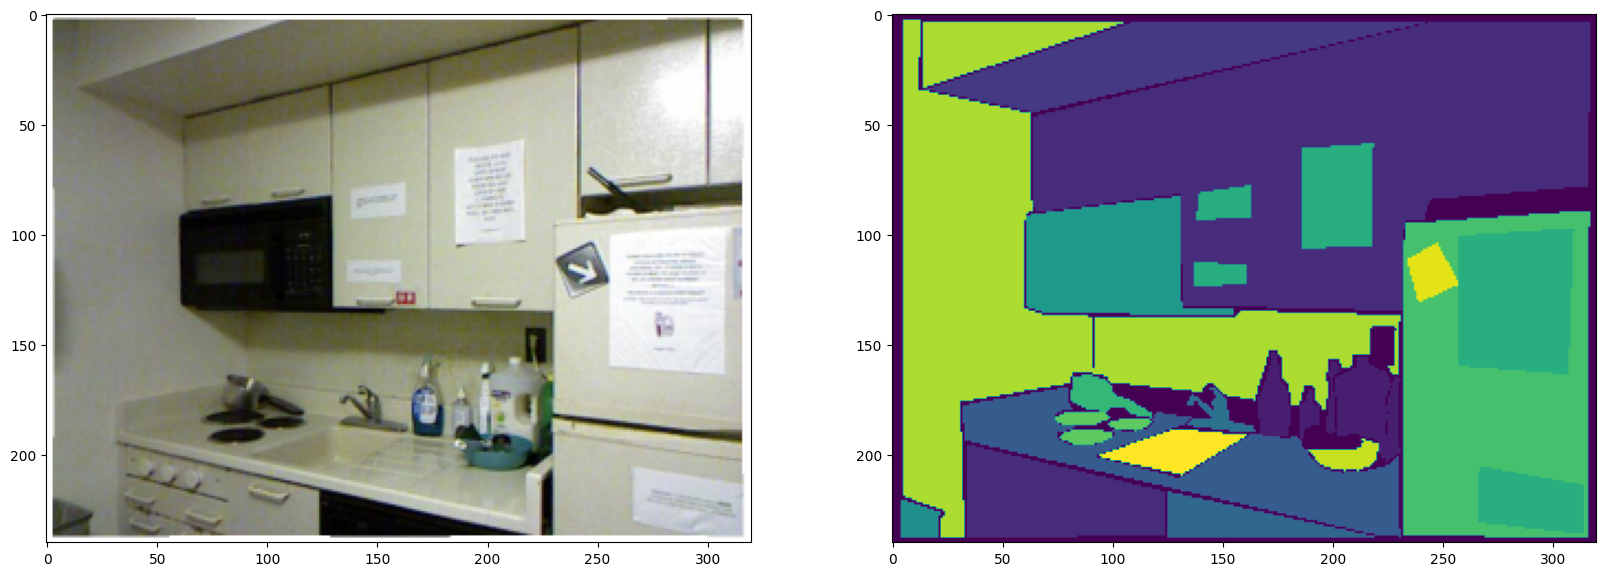

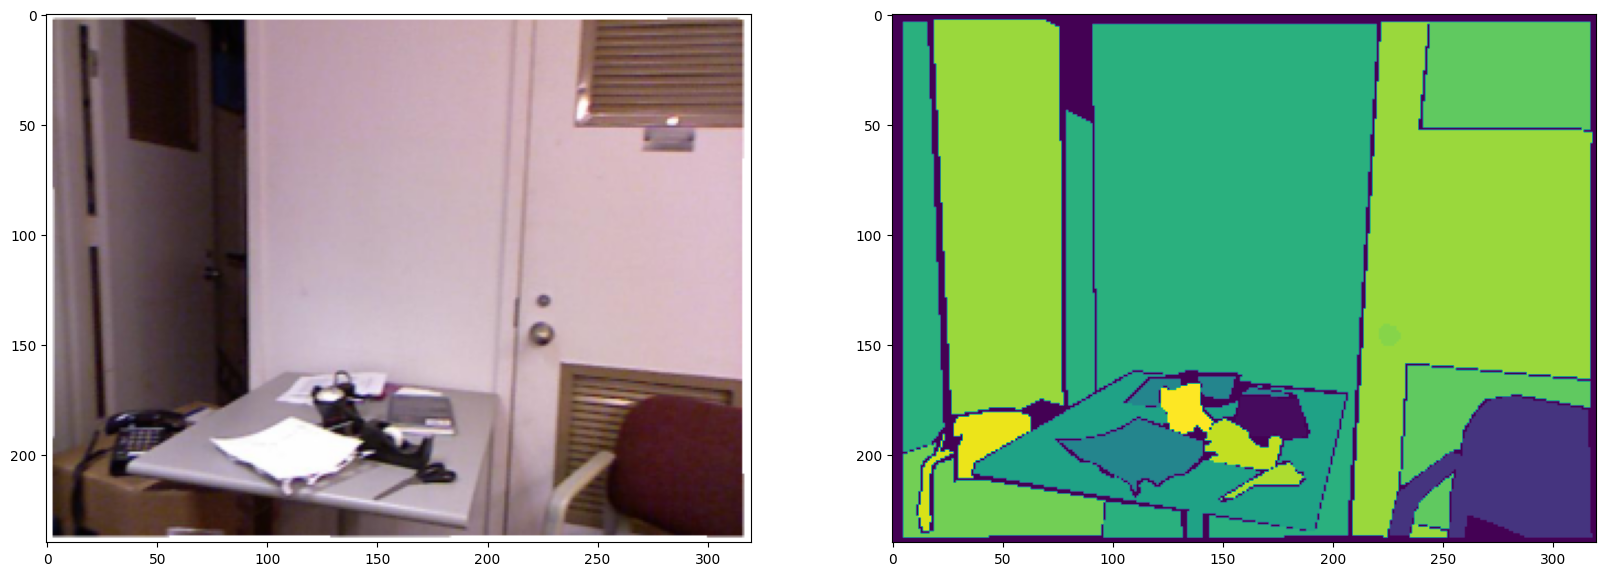

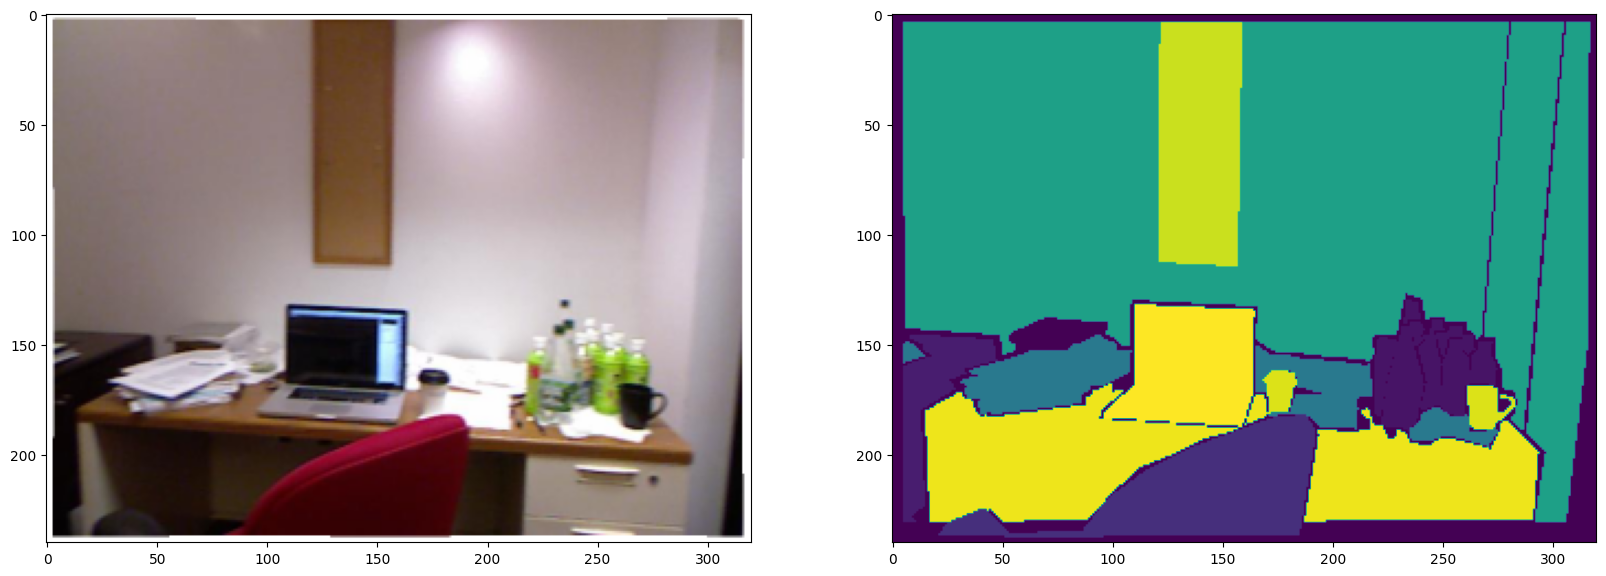

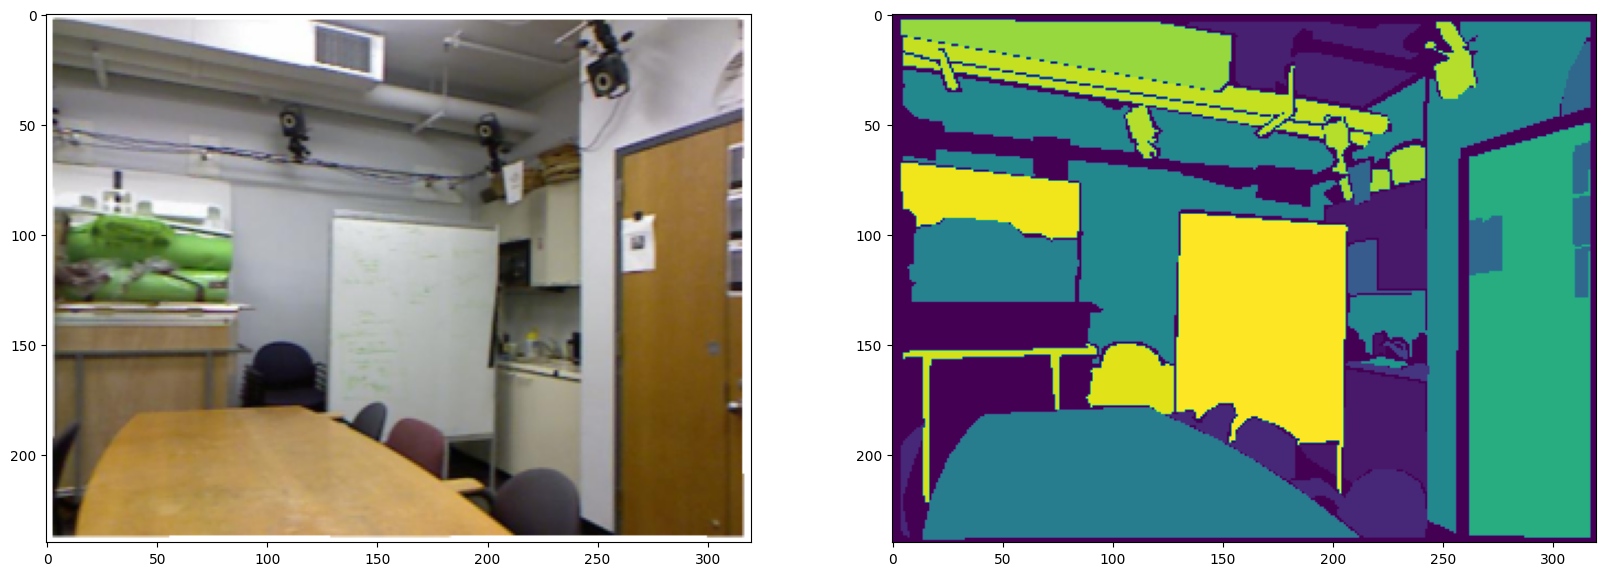

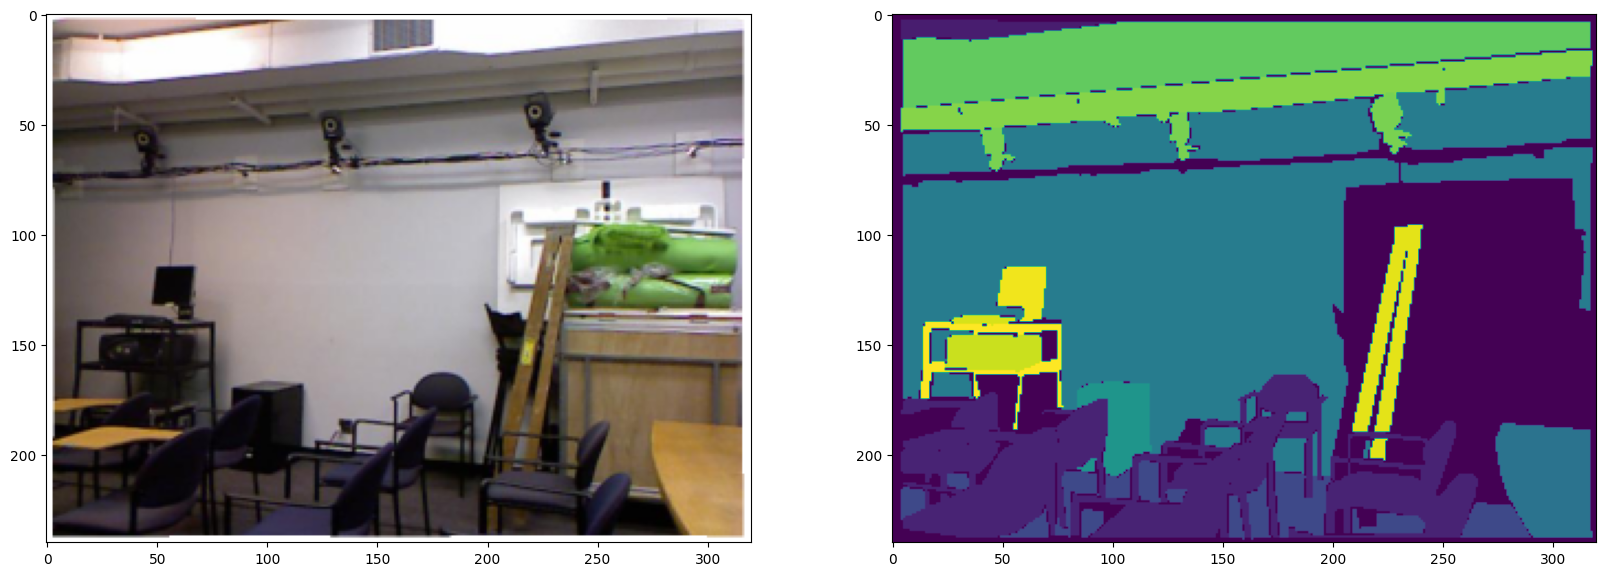

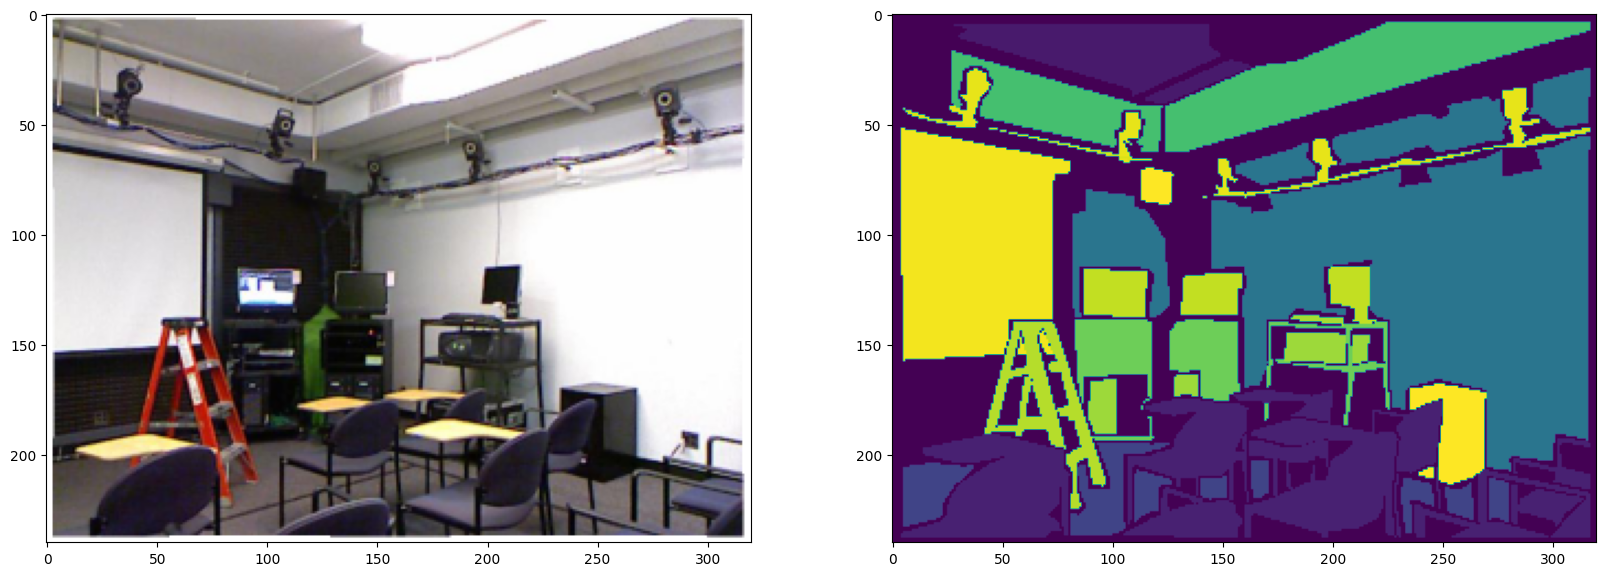

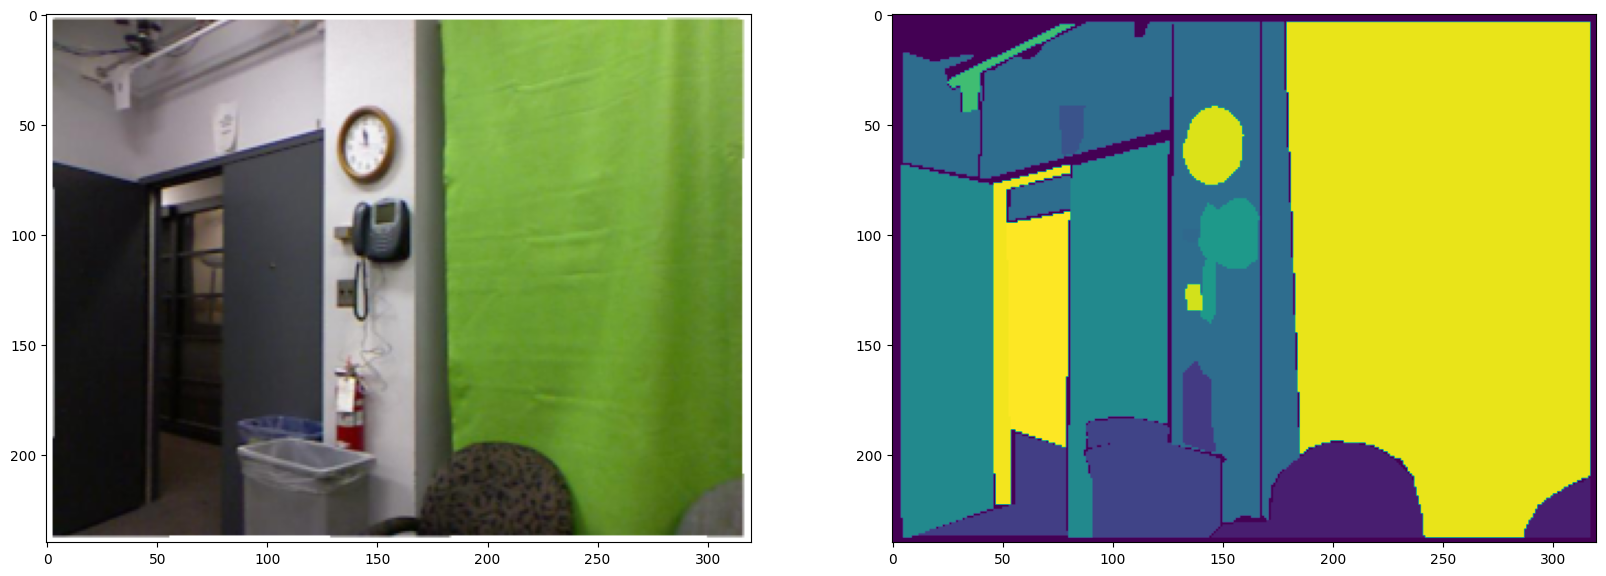

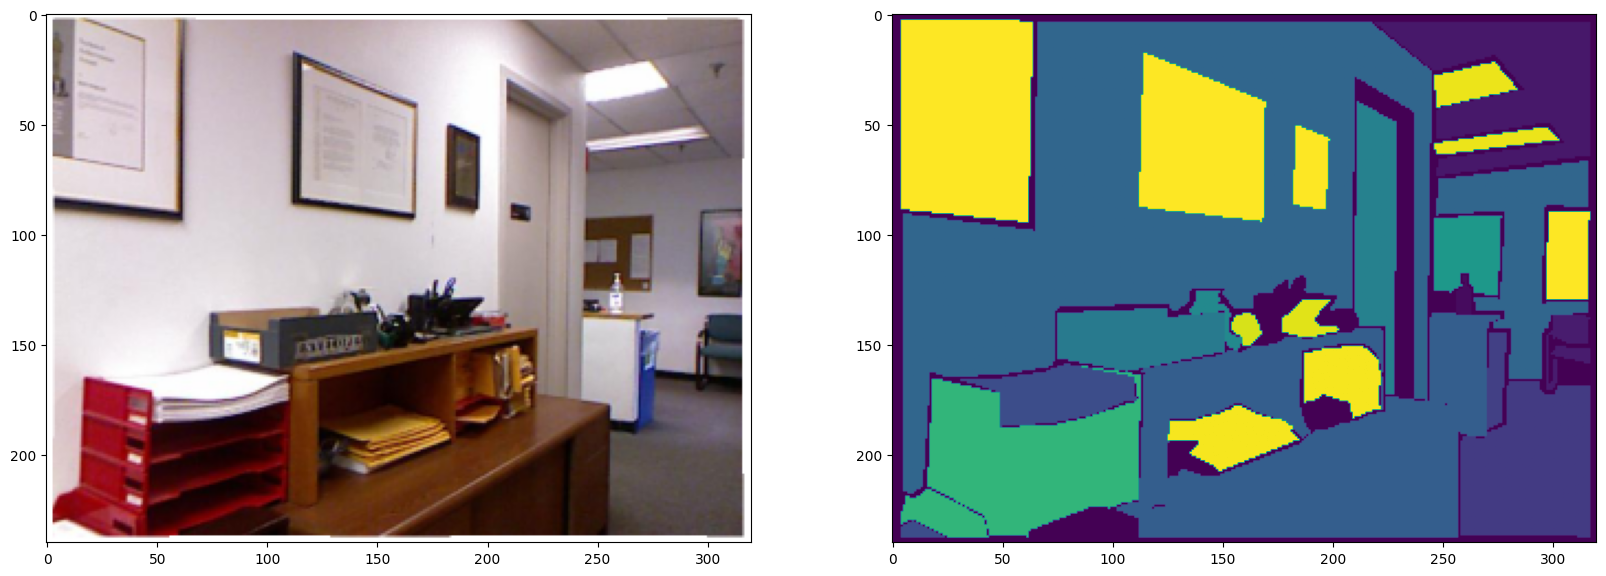

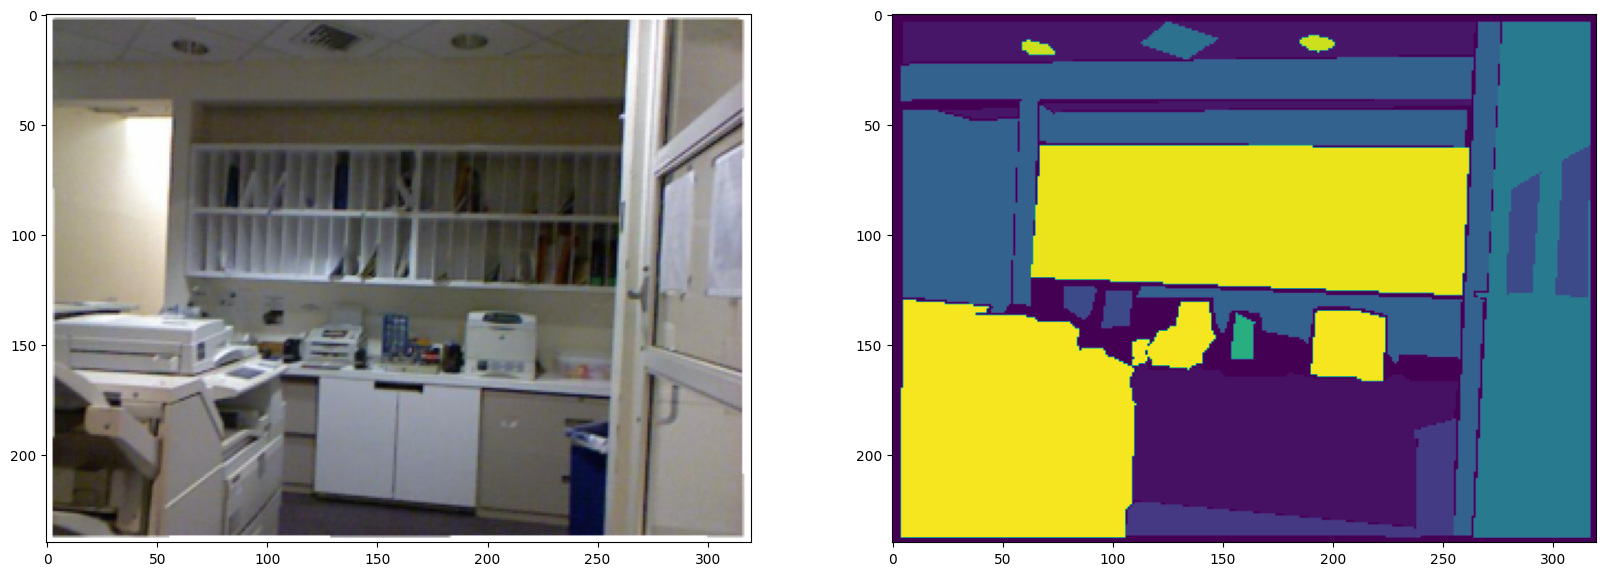

In [5]:
NYU_ds = NYU(raw_data, False, (240, 320))
for x in range(10):
    img, mask = NYU_ds[x]

    f, axarr = plt.subplots(1, 2, figsize=(20, 15))
    axarr[0].imshow(img.permute(1, -1, 0).numpy())
    axarr[1].imshow(mask.argmax(0).unsqueeze(0).permute(1, -1, 0).numpy())

In [6]:
train_dl = DataLoader(NYU_ds, batch_size=4, shuffle=True, pin_memory = True, num_workers=24)

print("#Training Samples: {}".format(len(NYU_ds)))
print("#Training Batch: {}".format(len(train_dl)))

#Training Samples: 1449
#Training Batch: 363


In [7]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

In [8]:
class Down(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

In [9]:
class Up(nn.Module):    

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [10]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [11]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 32))
        self.down1 = (Down(32, 64)) #64, 128
        self.down2 = (Down(64, 128)) #128, 256
        self.down3 = (Down(128, 256)) #256, 512
        factor = 2 if bilinear else 1
        self.down4 = (Down(256, 512 // factor)) #512, 1024
        self.up1 = (Up(512, 256 // factor, bilinear)) #1024, 512
        self.up2 = (Up(256, 128 // factor, bilinear)) #512, 256
        self.up3 = (Up(128, 64 // factor, bilinear)) #256, 128
        self.up4 = (Up(64, 32, bilinear)) #128, 64
        self.outc = (OutConv(32, n_classes)) #64

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [12]:
def dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all batches, or for a single mask
    assert input.size() == target.size()
    assert input.dim() == 3 or not reduce_batch_first

    sum_dim = (-1, -2) if input.dim() == 2 or not reduce_batch_first else (-1, -2, -3)

    inter = 2 * (input * target).sum(dim=sum_dim)
    sets_sum = input.sum(dim=sum_dim) + target.sum(dim=sum_dim)
    sets_sum = torch.where(sets_sum == 0, inter, sets_sum)

    dice = (inter + epsilon) / (sets_sum + epsilon)
    return dice.mean()


def multiclass_dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all classes
    return dice_coeff(input.flatten(0, 1), target.flatten(0, 1), reduce_batch_first, epsilon)


def dice_loss(input: Tensor, target: Tensor, multiclass: bool = False):
    # Dice loss (objective to minimize) between 0 and 1
    fn = multiclass_dice_coeff if multiclass else dice_coeff
    return 1 - fn(input, target, reduce_batch_first=True)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index = 0)

model = UNet(3, NYU_ds.cls_cnt, False).to(device)

optimizer = Adam(params = model.parameters(), lr = 0.001)

epochs = 100

scheduler = CosineAnnealingLR(optimizer, epochs * len(train_dl))

loss_fn = nn.CrossEntropyLoss()

In [ ]:
old_loss = 1e26
best_dct = None
last_dst = None
for epoch in range(epochs):
    model.train()
    tr_total_loss = 0
    for train_img, train_mask in tqdm(train_dl):
        train_img = train_img.to(device, dtype=torch.float)
        train_mask = train_mask.to(device)

        train_gen_mask = model(train_img)
        train_rec_loss = loss_fn(train_gen_mask, train_mask)
        train_dice_loss = dice_loss(
            F.softmax(train_gen_mask, dim=1).float(),
            train_mask.float(),
            multiclass=True
        )
        train_loss = train_rec_loss + train_dice_loss

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        scheduler.step()

        tr_total_loss += train_loss.cpu().item()

    # model.eval()
    # with torch.no_grad():
    #     va_total_loss = 0
    #     for valid_img, valid_mask in tqdm(train_dl):
    #         valid_img = valid_img.to(device)
    #         valid_mask = valid_mask.to(device)
            
    #         valid_gen_mask = model(valid_img)
    #         valid_loss = loss_fn(valid_gen_mask, valid_mask)
    #         valid_dice_loss = dice_loss(
    #             F.softmax(valid_gen_mask, dim=1).float(),
    #             valid_mask.float(),
    #             multiclass=True
    #         )
    #         valid_loss = train_rec_loss + train_dice_loss

    #         va_total_loss += valid_loss.cpu().item()
            
    mean_train_loss = tr_total_loss/len(train_dl)
    # mean_valid_loss = va_total_loss/len(test_dl)

    if mean_train_loss <= old_loss:
        old_loss = mean_train_loss
        best_dct = model.state_dict()
    
    last_dct = model.state_dict()

    print(f"Epoch: {epoch} - TrainLoss: {mean_train_loss}")
model.load_state_dict(best_dct)

100%|████████████████████████████████████████████████████████████████████| 363/363 [03:03<00:00,  1.98it/s]


Epoch: 0 - TrainLoss: 4.520564430672932


100%|████████████████████████████████████████████████████████████████████| 363/363 [02:50<00:00,  2.13it/s]


Epoch: 1 - TrainLoss: 3.4037444827970393


100%|████████████████████████████████████████████████████████████████████| 363/363 [02:52<00:00,  2.11it/s]


Epoch: 2 - TrainLoss: 3.302392000666006


100%|████████████████████████████████████████████████████████████████████| 363/363 [02:50<00:00,  2.12it/s]


Epoch: 3 - TrainLoss: 3.2327331294698163


100%|████████████████████████████████████████████████████████████████████| 363/363 [02:52<00:00,  2.10it/s]


Epoch: 4 - TrainLoss: 3.1653947350735834


100%|████████████████████████████████████████████████████████████████████| 363/363 [02:53<00:00,  2.10it/s]


Epoch: 5 - TrainLoss: 3.0989878210482846


100%|████████████████████████████████████████████████████████████████████| 363/363 [02:52<00:00,  2.11it/s]


Epoch: 6 - TrainLoss: 3.03342000249332


100%|████████████████████████████████████████████████████████████████████| 363/363 [02:51<00:00,  2.12it/s]


Epoch: 7 - TrainLoss: 2.97984810834417


100%|████████████████████████████████████████████████████████████████████| 363/363 [02:53<00:00,  2.10it/s]


Epoch: 8 - TrainLoss: 2.919736318351809


100%|████████████████████████████████████████████████████████████████████| 363/363 [02:52<00:00,  2.11it/s]


Epoch: 9 - TrainLoss: 2.8682447734286307


100%|████████████████████████████████████████████████████████████████████| 363/363 [02:52<00:00,  2.10it/s]


Epoch: 10 - TrainLoss: 2.822813464918741


100%|████████████████████████████████████████████████████████████████████| 363/363 [02:51<00:00,  2.12it/s]


Epoch: 11 - TrainLoss: 2.7706285613299073


100%|████████████████████████████████████████████████████████████████████| 363/363 [02:53<00:00,  2.09it/s]


Epoch: 12 - TrainLoss: 2.72394529650034


100%|████████████████████████████████████████████████████████████████████| 363/363 [02:51<00:00,  2.11it/s]


Epoch: 13 - TrainLoss: 2.67691633097068


100%|████████████████████████████████████████████████████████████████████| 363/363 [02:53<00:00,  2.10it/s]


Epoch: 14 - TrainLoss: 2.6334706341267946


100%|████████████████████████████████████████████████████████████████████| 363/363 [02:53<00:00,  2.10it/s]


Epoch: 15 - TrainLoss: 2.5926557707064077


100%|████████████████████████████████████████████████████████████████████| 363/363 [02:53<00:00,  2.09it/s]


Epoch: 16 - TrainLoss: 2.5495301242045465


100%|████████████████████████████████████████████████████████████████████| 363/363 [02:51<00:00,  2.12it/s]


Epoch: 17 - TrainLoss: 2.5080404278332207


100%|████████████████████████████████████████████████████████████████████| 363/363 [02:50<00:00,  2.13it/s]


Epoch: 18 - TrainLoss: 2.4633049849964697


100%|████████████████████████████████████████████████████████████████████| 363/363 [02:52<00:00,  2.10it/s]


Epoch: 19 - TrainLoss: 2.415027265706338


100%|████████████████████████████████████████████████████████████████████| 363/363 [02:52<00:00,  2.11it/s]


Epoch: 20 - TrainLoss: 2.364419177872419


100%|████████████████████████████████████████████████████████████████████| 363/363 [02:53<00:00,  2.10it/s]


Epoch: 21 - TrainLoss: 2.327531713099519


100%|████████████████████████████████████████████████████████████████████| 363/363 [02:54<00:00,  2.08it/s]


Epoch: 22 - TrainLoss: 2.283703379066194


100%|████████████████████████████████████████████████████████████████████| 363/363 [03:04<00:00,  1.97it/s]


Epoch: 23 - TrainLoss: 2.2250373925059295


100%|████████████████████████████████████████████████████████████████████| 363/363 [02:55<00:00,  2.07it/s]


Epoch: 24 - TrainLoss: 2.177851357079078


100%|████████████████████████████████████████████████████████████████████| 363/363 [02:55<00:00,  2.07it/s]


Epoch: 25 - TrainLoss: 2.1280963854356245


100%|████████████████████████████████████████████████████████████████████| 363/363 [02:55<00:00,  2.07it/s]


Epoch: 26 - TrainLoss: 2.0792200995542456


100%|████████████████████████████████████████████████████████████████████| 363/363 [02:59<00:00,  2.02it/s]


Epoch: 27 - TrainLoss: 2.028493264818323


100%|████████████████████████████████████████████████████████████████████| 363/363 [02:55<00:00,  2.06it/s]


Epoch: 28 - TrainLoss: 1.9667553018275699


100%|████████████████████████████████████████████████████████████████████| 363/363 [02:54<00:00,  2.08it/s]


Epoch: 29 - TrainLoss: 1.9159342861700976


100%|████████████████████████████████████████████████████████████████████| 363/363 [02:56<00:00,  2.06it/s]


Epoch: 30 - TrainLoss: 1.8539880294116733


100%|████████████████████████████████████████████████████████████████████| 363/363 [02:54<00:00,  2.08it/s]


Epoch: 31 - TrainLoss: 1.8064635144777534


100%|████████████████████████████████████████████████████████████████████| 363/363 [02:55<00:00,  2.06it/s]


Epoch: 32 - TrainLoss: 1.7505805843789386


100%|████████████████████████████████████████████████████████████████████| 363/363 [03:37<00:00,  1.67it/s]


Epoch: 33 - TrainLoss: 1.7036900783044904


100%|████████████████████████████████████████████████████████████████████| 363/363 [03:01<00:00,  1.99it/s]


Epoch: 34 - TrainLoss: 1.6494479951122905


100%|████████████████████████████████████████████████████████████████████| 363/363 [03:54<00:00,  1.55it/s]


Epoch: 35 - TrainLoss: 1.6037003225531459


100%|████████████████████████████████████████████████████████████████████| 363/363 [04:08<00:00,  1.46it/s]


Epoch: 36 - TrainLoss: 1.5507259147226318


100%|████████████████████████████████████████████████████████████████████| 363/363 [04:18<00:00,  1.41it/s]


Epoch: 37 - TrainLoss: 1.504639997955196


100%|████████████████████████████████████████████████████████████████████| 363/363 [03:05<00:00,  1.96it/s]


Epoch: 38 - TrainLoss: 1.4482405041203354


100%|██████████████████████████████████████████████████████████████████████████████████████████| 363/363 [03:13<00:00,  1.88it/s]


Epoch: 39 - TrainLoss: 1.41489613236803


100%|██████████████████████████████████████████████████████████████████████████████████████████| 363/363 [03:45<00:00,  1.61it/s]


Epoch: 40 - TrainLoss: 1.3596746333702865


100%|██████████████████████████████████████████████████████████████████████████████████████████| 363/363 [04:10<00:00,  1.45it/s]


Epoch: 41 - TrainLoss: 1.335270648488657


100%|██████████████████████████████████████████████████████████████████████████████████████████| 363/363 [04:45<00:00,  1.27it/s]


Epoch: 42 - TrainLoss: 1.2794940269683017


100%|██████████████████████████████████████████████████████████████████████████████████████████| 363/363 [04:48<00:00,  1.26it/s]


Epoch: 43 - TrainLoss: 1.245654585768697


100%|██████████████████████████████████████████████████████████████████████████████████████████| 363/363 [04:52<00:00,  1.24it/s]


Epoch: 44 - TrainLoss: 1.2123141193521252


100%|██████████████████████████████████████████████████████████████████████████████████████████| 363/363 [04:58<00:00,  1.22it/s]


Epoch: 45 - TrainLoss: 1.1650729630932664


100%|██████████████████████████████████████████████████████████████████████████████████████████| 363/363 [04:51<00:00,  1.24it/s]


Epoch: 46 - TrainLoss: 1.1291126812456724


100%|██████████████████████████████████████████████████████████████████████████████████████████| 363/363 [04:58<00:00,  1.22it/s]


Epoch: 47 - TrainLoss: 1.1062727785635913


100%|██████████████████████████████████████████████████████████████████████████████████████████| 363/363 [04:20<00:00,  1.39it/s]


Epoch: 48 - TrainLoss: 1.0867725945701283


100%|██████████████████████████████████████████████████████████████████████████████████████████| 363/363 [04:21<00:00,  1.39it/s]


Epoch: 49 - TrainLoss: 1.0455024767841519


100%|██████████████████████████████████████████████████████████████████████████████████████████| 363/363 [03:58<00:00,  1.52it/s]


Epoch: 50 - TrainLoss: 1.0123807382320897


100%|██████████████████████████████████████████████████████████████████████████████████████████| 363/363 [04:18<00:00,  1.41it/s]


Epoch: 51 - TrainLoss: 0.9927765856761249


100%|██████████████████████████████████████████████████████████████████████████████████████████| 363/363 [04:16<00:00,  1.41it/s]


Epoch: 52 - TrainLoss: 0.9661286965874601


100%|██████████████████████████████████████████████████████████████████████████████████████████| 363/363 [04:22<00:00,  1.38it/s]


Epoch: 53 - TrainLoss: 0.9286521750376573


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 363/363 [04:25<00:00,  1.37it/s]


Epoch: 54 - TrainLoss: 0.9049496791086906


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 363/363 [03:42<00:00,  1.63it/s]


Epoch: 55 - TrainLoss: 0.8959103431911837


100%|████████████████████████████████████████████████████████████████████| 363/363 [03:52<00:00,  1.56it/s]


Epoch: 56 - TrainLoss: 0.8668095118086528


  7%|████▌                                                                | 24/363 [00:48<01:15,  4.49it/s]

In [ ]:
model.eval()

with torch.no_grad():
    for test_case_idx in range(10):
        valid_img, valid_mask = NYU_ds[test_case_idx]
        valid_img = valid_img.unsqueeze(dim=0).to(device)

        gen_mask = model(valid_img)     
        # f, axarr = plt.subplots(1, total_num_class + 3, figsize = (20,15))
        f, axarr = plt.subplots(1, 2, figsize = (20,15))
        axarr[0].imshow(valid_img[0].cpu().permute(1, -1, 0).numpy())
        axarr[0].axis('off')
        axarr[1].imshow(torch.argmax(gen_mask[0], dim=0).cpu().unsqueeze(0).permute(1, -1, 0).numpy())
        axarr[1].axis('off')
        # for idx in range(total_num_class):
        #     axarr[idx + 2].imshow(gen_mask[0][idx].unsqueeze(0).cpu().permute(1, -1, 0).numpy())
        #     axarr[idx + 2].axis('off')
        # axarr[total_num_class+2].imshow(torch.argmax(valid_mask, dim=0).unsqueeze(0).cpu().permute(1, -1, 0).numpy())
        # axarr[total_num_class+2].axis('off')